# Image Processing Lab №8
Textural analysis and contrast

In [37]:
import os
import ast
import string
import numpy as np
import pandas as pd
from PIL import Image
from IPython.display import display
from tqdm import tqdm

from typing import Tuple

import matplotlib.pyplot as plt

from pathlib import Path

In [2]:
def open_image(image_name=None, images_dir=None):
    if images_dir:
        image_list = []
        for path in images_dir.iterdir():
            image = Image.open(path)
            image_list.append(image)
        return image_list

    image_folder = Path('input/'+image_name)
    try:
        image = Image.open(image_folder)
    except FileNotFoundError:
        print(f'Image file not found: {image_folder}')
    
    return image

pth = Path('input/')

In [3]:
def display_image(img):
    display(Image.fromarray(img.astype(np.uint8)))

In [4]:
def save_image(path: str, img: np.array):
    Image.fromarray(img.astype(np.uint8)).save(path)

In [6]:
file_list = os.listdir('input/')
file_list.remove('.DS_Store')

file_list

['fire.png',
 'minecraft_wood.png',
 'gravel.png',
 'silver.png',
 'diamond.png',
 'fractal.png']

In [16]:
image_list = []

for file in file_list:
    image_list.append(open_image(file))

In [17]:
numpy_image_list = list(map(np.array, image_list))

In [18]:
for i in range(len(numpy_image_list)):
    numpy_image_list[i] = numpy_image_list[i][:189,:224,:]

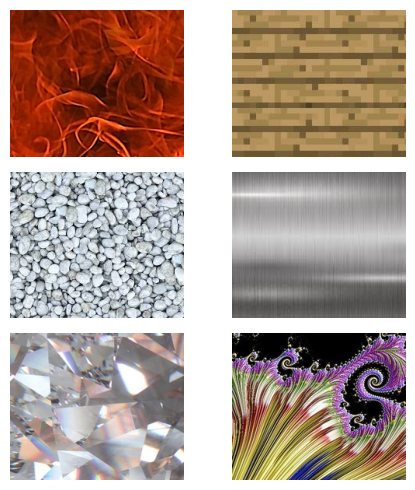

In [29]:
plt.figure(figsize=(5, 5))

for i in range(1, 7):
    plt.subplot(3, 2, i)
    plt.imshow(numpy_image_list[i-1])
    plt.axis('off')

plt.tight_layout()
plt.show()

In [23]:
def convert_to_grayscale(img: np.array):
    grayscaled_img = np.mean(img, axis=2)
    return np.squeeze(grayscaled_img[:, :, np.newaxis], axis=2).astype(np.uint8)

In [24]:
gs_image_list = list(map(convert_to_grayscale, numpy_image_list))

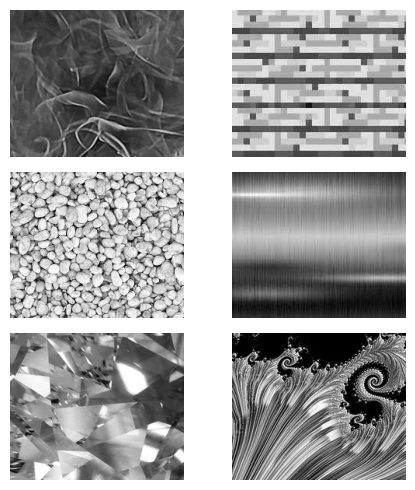

In [31]:
plt.figure(figsize=(5, 5))

for i in range(1, 7):
    plt.subplot(3, 2, i)
    plt.imshow(gs_image_list[i-1], cmap='gray')
    plt.axis('off')

plt.tight_layout()
plt.show()

In [32]:
def power_transform(image, gamma):
    image_normalized = image.astype(np.float32) / 255.0
    transformed_image = np.power(image_normalized, gamma)
    return (transformed_image * 255).astype(np.uint8)

In [34]:
contrasted_image_list = list(map(lambda x: power_transform(x, 1.5), gs_image_list))

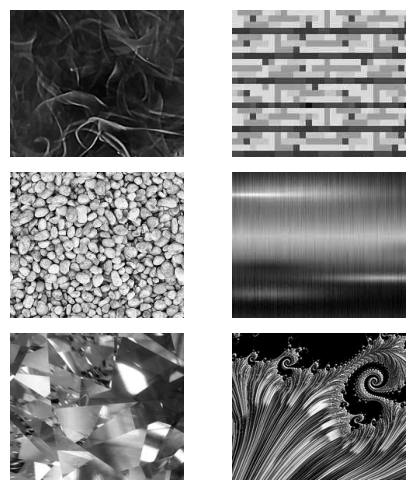

In [35]:
plt.figure(figsize=(5, 5))

for i in range(1, 7):
    plt.subplot(3, 2, i)
    plt.imshow(contrasted_image_list[i-1], cmap='gray')
    plt.axis('off')

plt.tight_layout()
plt.show()

## GLCM Calculation

In [36]:
d = 1
phi = (45, 135, 225, 315)

In [43]:
class GLCMTransformer:
    def __init__(self, d: int, phi: Tuple):
        self.d = d

        # works only for 45, 135, 225, 315 sorry :(
        self.phi = phi
    
    def calculate(self, image: np.array):
        GLCMMatrix = np.zeros(shape=(256, 256))

        for i in range(1, image.shape[0]-1):
            for j in range(1, image.shape[1]-1):
                GLCMMatrix[image[i,j], image[i-1, j-1]] += 1
                GLCMMatrix[image[i,j], image[i+1, j+1]] += 1
                GLCMMatrix[image[i,j], image[i-1, j+1]] += 1
                GLCMMatrix[image[i,j], image[i+1, j-1]] += 1

        return GLCMMatrix.astype(np.uint8)


In [80]:
def calculate_corr(glcm: np.array):
    P_j = glcm.sum(axis=0)
    P_i = glcm.sum(axis=1)

    nu_j = np.array([i*item for i, item in enumerate(P_j)]).sum()
    nu_i = np.array([i*item for i, item in enumerate(P_i)]).sum()

    sigma_i = np.array([(j - nu_i)**2 * P_i[j] for j in range(glcm.shape[1])]).sum()
    sigma_j = np.array([(i - nu_j)**2 * P_j[i] for i in range(glcm.shape[0])]).sum()

    corr = 0

    for i in range(glcm.shape[0]):
        for j in range(glcm.shape[1]):
            corr += i*j*glcm[i,j]

    return (corr - nu_i*nu_j)/(np.sqrt(sigma_i)*np.sqrt(sigma_j))


In [44]:
glcmtransformer = GLCMTransformer(d, phi)

In [53]:
gs_glcm_image_list = list(map(glcmtransformer.calculate, gs_image_list))
contrasted_glcm_image_list = list(map(glcmtransformer.calculate, contrasted_image_list))

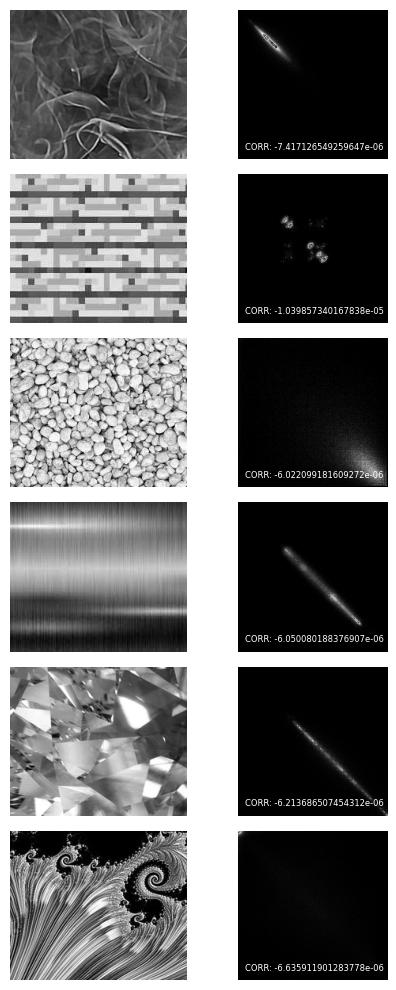

In [85]:
plt.figure(figsize=(5, 10))

for i in range(1, 13):
    if i % 2 == 1:
        plt.subplot(6, 2, i)
        plt.imshow(gs_image_list[(i-1)//2], cmap='gray')
        plt.axis('off')
    else:
        plt.subplot(6, 2, i)
        plt.imshow(gs_glcm_image_list[(i-1)//2], cmap='gray')
        plt.text(0.05, 0.05, f'CORR: {calculate_corr(gs_glcm_image_list[(i-1)//2])}', color='white', fontsize=6, ha='left', va='bottom', transform=plt.gca().transAxes)
        plt.axis('off')


plt.tight_layout()
plt.show()

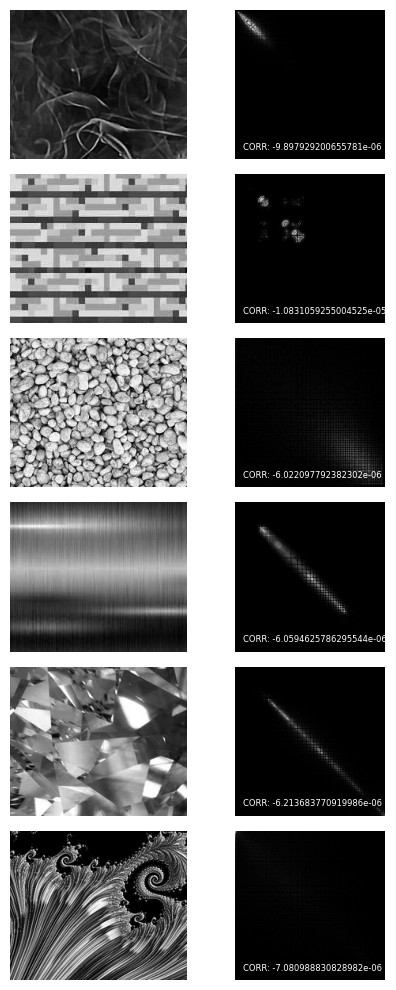

In [87]:
plt.figure(figsize=(5, 10))

for i in range(1, 13):
    if i % 2 == 1:
        plt.subplot(6, 2, i)
        plt.imshow(contrasted_image_list[(i-1)//2], cmap='gray')
        plt.axis('off')
    else:
        plt.subplot(6, 2, i)
        plt.imshow(contrasted_glcm_image_list[(i-1)//2], cmap='gray')
        plt.text(0.05, 0.05, f'CORR: {calculate_corr(contrasted_glcm_image_list[(i-1)//2])}', color='white', fontsize=6, ha='left', va='bottom', transform=plt.gca().transAxes)
        plt.axis('off')


plt.tight_layout()
plt.show()

In [61]:
np.array([[1, 2, 4],
          [3, 5, 7]]).sum(axis=1)

array([ 7, 15])